In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# setup
TRAIN_PATH = "../input/titanic/train.csv"
TEST_PATH = "../input/titanic/test.csv"
SUBMISSION_PATH = "../input/titanic/gender_submission.csv"

OUTPUT_PATH = "../output/submission.csv"

In [3]:
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [4]:
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


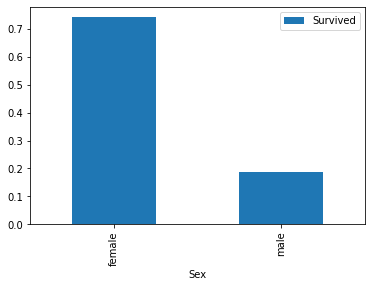

In [5]:
gender_df = train_df[["PassengerId", "Survived", "Sex"]].copy()
gender_pivot_df = gender_df.groupby("Sex").agg({"Survived": np.mean})
gender_pivot_df.plot.bar()
plt.show()

In [6]:
# create baseline gender model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score


def create_dummies(df, feature):
    dummy_df = pd.get_dummies(data = df[feature], prefix = feature)
    df = pd.concat([df, dummy_df], axis=1)
    new_df = df.drop(columns = feature)
    return new_df

def cross_validate(model, df, features, target):
    all_X = df[features]
    all_y = df[target]
    scores = cross_val_score(model, all_X, all_y, cv = 10)
    accuracy_lr = np.mean(scores)
    return accuracy_lr

def train_model(model, df, features, target):
    model.fit(df[features], df[target])
    return model

def generate_predictions(model, df, features):
    predictions = model.predict(df[features])
    return predictions

In [7]:
# cross validate
version1 = create_dummies(train_df, "Sex")
features = ["Sex_male", "Sex_female"]
target = "Survived"
model = LogisticRegression()
acc = cross_validate(model, version1, features, target)
print(acc)

# generate the baseline model
lr = train_model(model, version1, features, target)

# generate predictions
test_version1 = create_dummies(test_df, "Sex")
predictions = generate_predictions(lr, test_version1, features)

0.786729088639201


In [8]:
lr.coef_

array([[-1.23963654,  1.23958792]])

In [9]:
predictions[0:10]

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0])

In [10]:
# passenger_ids = test_df["PassengerId"]
# prediction = predictions
# submission = pd.DataFrame(
#     {
#         "PassengerId": passenger_ids,
#         "Survived": prediction
#     }
# )

# submission.to_csv("submission.csv", index=False)

Baseline gender model -> score of 0.7655

<AxesSubplot:ylabel='Pclass'>

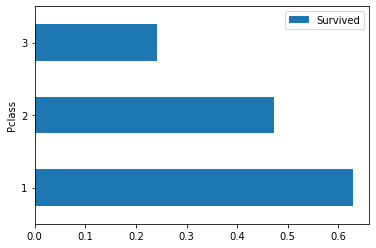

In [11]:
# Lets build on top of the baseline gender model and try to improve the accuracy
# Lets look at the PClass column and Embarked columns
p_class_df = train_df[["Pclass", "PassengerId", "Survived"]].copy()
p_class_agg = p_class_df.groupby("Pclass").agg({"Survived": np.mean})
p_class_agg.plot.barh()

<AxesSubplot:ylabel='Embarked'>

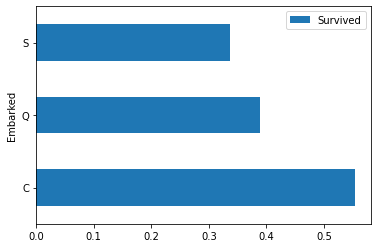

In [12]:
embarked_df = train_df[["Embarked", "PassengerId", "Survived"]].copy()
embarked_agg = embarked_df.groupby("Embarked").agg({"Survived": np.mean})
embarked_agg.plot.barh()

In [13]:
# Building a combination of the gender, Embarked, Pclass column
cols = ["Sex", "Pclass", "Embarked"]
version2 = train_df.copy()
for col in cols:
    version2 = create_dummies(version2, col)
    
version2.head(4)

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,1,0,0,0,0,1


In [14]:
features = ["Pclass_1", "Pclass_2", "Pclass_3", "Sex_female", "Sex_male", "Embarked_C", "Embarked_Q", "Embarked_S"]
target = "Survived"
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

acc = cross_validate(model, version2, features, target)
print(acc)

# generate the baseline model
lr = train_model(model, version2, features, target)

# generate predictions
test_version2 = test_df.copy()
for col in cols:
    test_version2 = create_dummies(test_version2, col)

predictions2 = generate_predictions(lr, test_version2, features)

0.8114357053682897


In [15]:
lr.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [16]:
# passenger_ids = test_df["PassengerId"]
# prediction2 = predictions2
# submission = pd.DataFrame(
#     {
#         "PassengerId": passenger_ids,
#         "Survived": prediction2
#     }
# )

# submission.to_csv("submission.csv", index=False)


After adding DecisionTree classifier with Pclass, Sex and Embarked columns, the accuracy went up to 0.77751

In [17]:
# Lets look at the other columns and perform some feature engineering
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [18]:
train_df[train_df["Age"].isnull()].head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q


<AxesSubplot:ylabel='Frequency'>

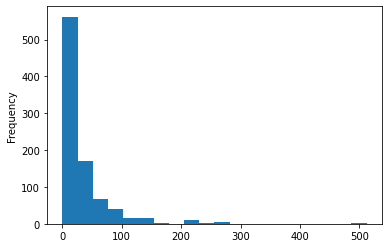

In [19]:
train_df["Fare"].plot.hist(bins = 20)

In [20]:
train_df["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [21]:
def process_fare(df):
    cut_points = [-1, 10, 15, 50, 100, 1000]
    labels = ["<10", "10-15", "15-50", "50-100", "100-1000"]
    df["Fare_category"] = pd.cut(df["Fare"], bins = cut_points, labels=labels)
    return df

# process age
def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_category"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_name(df):
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df


In [22]:
fare_df = process_fare(train_df)

In [23]:
fare_df.groupby("Fare_category").size()

Fare_category
<10         336
10-15       122
15-50       273
50-100      107
100-1000     53
dtype: int64

<AxesSubplot:ylabel='Fare_category'>

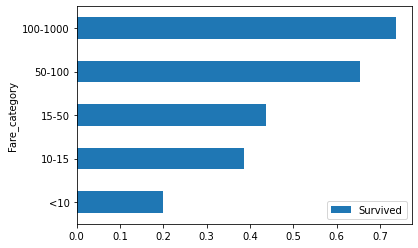

In [24]:
fare_df.groupby("Fare_category").agg({"Survived": np.mean}).plot.barh()

In [25]:
age_df = process_age(train_df)
age_df.groupby("Age_category").size()

Age_category
Missing        177
Infant          44
Child           25
Teenager        70
Young Adult    358
Adult          195
Senior          22
dtype: int64

<AxesSubplot:ylabel='Age_category'>

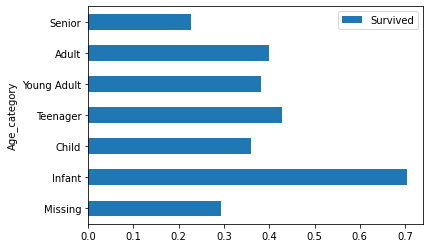

In [26]:
age_df.groupby("Age_category").agg({"Survived": np.mean}).plot.barh()

<AxesSubplot:ylabel='Title'>

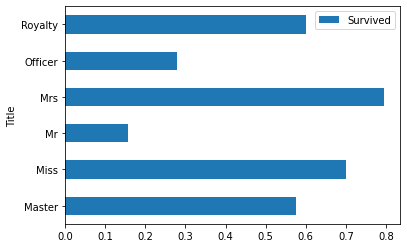

In [27]:
name_df = process_name(train_df)
name_df.groupby("Title").agg({"Survived": np.mean}).plot.barh()

In [28]:
# Building a more sophisticated model
cols = ["Sex", "Pclass", "Embarked", "Fare_category", "Age_category", "Title"]
version3 = train_df.copy()
version3 = process_fare(version3)
version3 = process_age(version3)
version3 = process_name(version3)
for col in cols:
    version3 = create_dummies(version3, col)
    
version3.head(4)

,PassengerId,Survived,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Sex_female,...,Age_category_Teenager,Age_category_Young Adult,Age_category_Adult,Age_category_Senior,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,...,0,1,0,0,0,0,1,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,...,0,0,1,0,0,0,0,1,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,...,0,1,0,0,0,1,0,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,...,0,1,0,0,0,0,0,1,0,0


In [29]:
features = ["Pclass_1", "Pclass_2", "Pclass_3", 
            "Sex_female", "Sex_male", 
            "Embarked_C", "Embarked_Q", "Embarked_S",
            "Fare_category_<10", "Fare_category_10-15", "Fare_category_15-50", "Fare_category_50-100", "Fare_category_100-1000",
            "Age_category_Missing", "Age_category_Infant", "Age_category_Child", "Age_category_Teenager", "Age_category_Young Adult", "Age_category_Adult", "Age_category_Senior",
            "Title_Master", "Title_Miss", "Title_Mr", "Title_Mrs", "Title_Officer", "Title_Royalty"]
target = "Survived"
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=1)

acc = cross_validate(model, version3, features, target)
print(acc)

# generate the model
lr = train_model(model, version3, features, target)

# generate predictions
test_version3 = test_df.copy()
test_version3 = process_fare(test_version3)
test_version3 = process_age(test_version3)
test_version3 = process_name(test_version3)

for col in cols:
    test_version3 = create_dummies(test_version3, col)

predictions3 = generate_predictions(lr, test_version3, features)

0.8159675405742821


In [30]:
from sklearn.feature_selection import RFECV

def select_features(X, Y, model):
    selector = RFECV(model,cv=10)
    selector.fit(X, Y)
    
    best_columns = list(X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

In [31]:
clf = RandomForestClassifier(random_state = 1)
# all_X = version3[features]
# all_Y = version3[target]
# best_features = select_features(all_X, all_Y, clf)

In [32]:
best_features = ['Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 
                 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare_category_<10', 
                 'Fare_category_10-15', 'Fare_category_15-50', 'Fare_category_50-100', 
                 'Fare_category_100-1000', 'Age_category_Missing', 'Age_category_Infant', 
                 'Age_category_Child', 'Age_category_Teenager', 'Age_category_Young Adult', 
                 'Age_category_Adult', 'Age_category_Senior', 'Title_Master', 'Title_Miss', 
                 'Title_Mr', 'Title_Mrs']

In [33]:
# generate the model
clf = RandomForestClassifier(random_state = 1)

acc = cross_validate(clf, version3, best_features, target)
print(acc)

lr = train_model(clf, version3, best_features, target)

# generate predictions
test_version3 = test_df.copy()
test_version3 = process_fare(test_version3)
test_version3 = process_age(test_version3)
test_version3 = process_name(test_version3)

for col in cols:
    test_version3 = create_dummies(test_version3, col)

predictions3 = generate_predictions(lr, test_version3, best_features)

0.8125967540574282


In [34]:
# # hyperparameter tuning using the GridSearchCV
# from sklearn.model_selection import GridSearchCV

# rfclassifier = \
# {
#     "name": "RandomForestClassifier",
#     "estimator": RandomForestClassifier(random_state=1),
#     "hyperparameters":
#         {
#             "n_estimators": [25, 50, 100, 125],
#             "criterion": ["entropy", "gini"],
#             "max_depth": [5, 10],
#             "max_features": ["log2", "sqrt"],
#             "min_samples_leaf": [3, 6],
#             "min_samples_split": [3, 6]

#         }
# }
# grid = GridSearchCV(rfclassifier["estimator"],
#                             param_grid=rfclassifier["hyperparameters"],
#                             cv=10)
# grid.fit(version3[best_features],version3[target])

# print("Best Score: {}".format(grid.best_score_))
# print("Best Parameters: {}\n".format(grid.best_params_))

# final_model = grid.best_estimator_

In [35]:
best_features

['Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Fare_category_<10',
 'Fare_category_10-15',
 'Fare_category_15-50',
 'Fare_category_50-100',
 'Fare_category_100-1000',
 'Age_category_Missing',
 'Age_category_Infant',
 'Age_category_Child',
 'Age_category_Teenager',
 'Age_category_Young Adult',
 'Age_category_Adult',
 'Age_category_Senior',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs']

In [36]:
final_model = RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                       min_samples_leaf=6, min_samples_split=3, n_estimators=50,
                       random_state=1)

acc = cross_validate(final_model, version3, best_features, target)
print(acc)

lr = train_model(final_model, version3, best_features, target)

# generate predictions
test_version3 = test_df.copy()
test_version3 = process_fare(test_version3)
test_version3 = process_age(test_version3)
test_version3 = process_name(test_version3)

for col in cols:
    test_version3 = create_dummies(test_version3, col)

predictions3 = generate_predictions(lr, test_version3, best_features)

0.8227215980024969


In [37]:
passenger_ids = test_df["PassengerId"]
prediction3 = predictions3
submission = pd.DataFrame(
    {
        "PassengerId": passenger_ids,
        "Survived": prediction3
    }
)

submission.to_csv("submission.csv", index=False)


In [38]:
# # hyperparameter tuning using the GridSearchCV
# from sklearn.model_selection import GridSearchCV

# rfclassifier = \
# {
#     "name": "RandomForestClassifier",
#     "estimator": RandomForestClassifier(random_state=1),
#     "hyperparameters":
#         {
#             "n_estimators": [10, 25, 50, 100],
#             "criterion": ["entropy", "gini"],
#             "max_depth": [2, 5, 10, 15, 20],
#             "max_features": ["log2", "sqrt"],
#             "min_samples_leaf": [1, 3, 5, 7, 9],
#             "min_samples_split": [2, 3, 5, 7, 9]

#         }
# }
# grid = GridSearchCV(rfclassifier["estimator"],
#                             param_grid=rfclassifier["hyperparameters"],
#                             cv=10)
# grid.fit(version3[features],version3[target])

# print("Best Score: {}".format(grid.best_score_))
# print("Best Parameters: {}\n".format(grid.best_params_))

# final_model = grid.best_estimator_

In [39]:
# final_model

In [40]:
# # generate predictions
# test_version3 = test_df.copy()
# test_version3 = process_fare(test_version3)

# for col in cols:
#     test_version3 = create_dummies(test_version3, col)

# predictions3 = generate_predictions(final_model, test_version3, features)

In [41]:
# passenger_ids = test_df["PassengerId"]
# prediction3 = predictions3
# submission = pd.DataFrame(
#     {
#         "PassengerId": passenger_ids,
#         "Survived": prediction3
#     }
# )

# submission.to_csv("submission.csv", index=False)


In [42]:
# test_version3.head()